In [1]:
import os
import pandas as pd
import seaborn as sns   
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
import numpy as np
from statsmodels.formula.api import ols
from tueplots import bundles


In [2]:
data_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
merged_data = pd.read_csv(os.path.join(data_folder, 'merged_dataset.csv'))
merged_data.head()

,title,author,aff,university_affiliation,university_country,company_affiliation,company_country,abstract,site,oa,...,track,status,ieee_link,ieee_keywords,ieee_index_terms,ieee_author_keywords,ieee_citations,ieee_abstract,Conference,Year
0,2.5D Visual Sound,Ruohan Gao; Kristen Grauman,Facebook AI Research; The University of Texas ...,50.0,['United States'],50.0,['United States'],Binaural audio provides a listener with 3D sou...,NaN,https://openaccess.thecvf.com/content_CVPR_201...,...,main,Oral,https://ieeexplore.ieee.org/document/8953465/,NaN,"['Visual Information', 'Deep Convolutional Neu...","['Video Analytics', 'Recognition: Detection', ...",123.0,Binaural audio provides a listener with 3D sou...,cvpr,2019
1,3D Appearance Super-Resolution With Deep Learning,Yawei Li; Vagia Tsiminaki; Radu Timofte; Marc ...,"Computer Vision and Geometry Group, ETH Zurich...",100.0,"['United States', 'Switzerland']",0.0,[],We tackle the problem of retrieving high-resol...,NaN,https://openaccess.thecvf.com/content_CVPR_201...,...,main,Poster,https://ieeexplore.ieee.org/document/8953787/,NaN,"['Super-resolution', '3D Super-resolution', 'D...","['3D from Multiview and Sensors', 'Datasets an...",16.0,We tackle the problem of retrieving high-resol...,cvpr,2019
2,3D Guided Fine-Grained Face Manipulation,Zhenglin Geng; Chen Cao; Sergey Tulyakov,Stanford University; Snap Inc.,50.0,['United States'],50.0,['United States'],We present a method for fine-grained face mani...,NaN,https://openaccess.thecvf.com/content_CVPR_201...,...,main,Poster,https://ieeexplore.ieee.org/document/8954233/,NaN,"['Use Of Face', 'Quantitative Data', 'Loss Fun...","['Face', 'Gesture', 'and Body Pose', 'Image an...",61.0,We present a method for fine-grained face mani...,cvpr,2019
3,3D Hand Shape and Pose Estimation From a Singl...,Liuhao Ge; Zhou Ren; Yuncheng Li; Zehao Xue; Y...,State University of New York at Buffalo; Wormp...,50.0,"['United States', 'Singapore']",50.0,['China'],This work addresses a novel and challenging pr...,NaN,https://openaccess.thecvf.com/content_CVPR_201...,...,main,Oral,https://ieeexplore.ieee.org/document/8953612/,NaN,"['Single Image', 'RGB Images', '3D Shape', 'Po...","['Face', 'Gesture', 'and Body Pose', '3D from ...",312.0,This work addresses a novel and challenging pr...,cvpr,2019
4,3D Hand Shape and Pose From Images in the Wild,Adnane Boukhayma; Rodrigo de Bem; Philip H.S. ...,"Federal University of Rio Grande, Brazil; Univ...",100.0,"['United Kingdom', 'Brazil']",0.0,[],We present in this work the first end-to-end d...,NaN,https://openaccess.thecvf.com/content_CVPR_201...,...,main,Oral,https://ieeexplore.ieee.org/document/8953961/,NaN,"['3D Shape', '3D Pose', 'Hand Shape', '3D Hand...","['Face', 'Gesture', 'and Body Pose', '3D from ...",244.0,We present in this work the first end-to-end d...,cvpr,2019


- **Null Hypothesis (H₀)**: µ₁ = µ₂ = µ₃ (The mean `ieee_citations` is the same across all three groups: academia, industry, and both).
- **Alternative Hypothesis (H₁)**: At least one of µ₁, µ₂, or µ₃ is different (The mean `ieee_citations` differs between at least two groups).


In [3]:
# Check for missing values
print(merged_data[['company_affiliation', 'university_affiliation']].isnull().sum())

# Check for non-numeric entries
print(merged_data[['company_affiliation', 'university_affiliation']].applymap(type).nunique())

# Drop or handle missing values
merged_data = merged_data.dropna(subset=['company_affiliation', 'university_affiliation'])

# Ensure data is numeric
merged_data['company_affiliation'] = pd.to_numeric(merged_data['company_affiliation'], errors='coerce')
merged_data['university_affiliation'] = pd.to_numeric(merged_data['university_affiliation'], errors='coerce')

# Drop any remaining NaN values after conversion
merged_data = merged_data.dropna(subset=['company_affiliation', 'university_affiliation'])

company_affiliation       154
university_affiliation    154
dtype: int64
company_affiliation       1
university_affiliation    1
dtype: int64


In [4]:
# Create weighted scores for academia and industry based on the percentages
merged_data['academia_score'] = merged_data['university_affiliation'] / 100
merged_data['industry_score'] = merged_data['company_affiliation'] / 100

# Now, for each paper, we can combine these scores into a single academic vs. industry classification
academia_citations = merged_data[merged_data['academia_score'] == 1]['ieee_citations']
industry_citations = merged_data[merged_data['industry_score'] > 0]['ieee_citations']
# both_citations = merged_data[(merged_data['academia_score'] == 0.5) & (merged_data['industry_score'] == 0.5)]['ieee_citations']

In [5]:
print(academia_citations.isna().sum())  # Check for NaN values in academia citations
print(industry_citations.isna().sum())  # Check for NaN values in industry citations
# print(both_citations.isna().sum())      # Check for NaN values in both citations

academia_citations = academia_citations.dropna()
industry_citations = industry_citations.dropna()
# both_citations = both_citations.dropna()

print(len(academia_citations))  # Number of samples in academia group
print(len(industry_citations))  # Number of samples in industry group
# print(len(both_citations))     # Number of samples in both group

1281
854
9337
7285


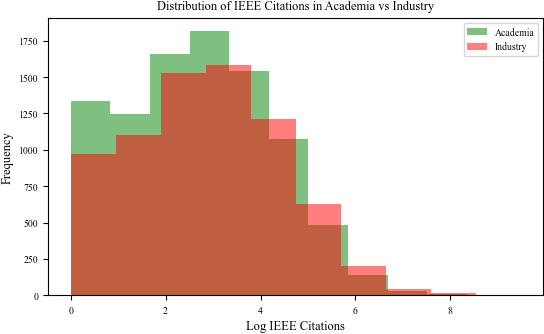

In [6]:
bundles.neurips2023(usetex=True)
plt.rcParams.update(bundles.neurips2023(usetex=False))


plt.hist(np.log(academia_citations), alpha=0.5, label='Academia', color='green')
plt.hist(np.log(industry_citations), alpha=0.5, label='Industry', color='red')
# plt.hist(np.log(both_citations), bins=25, alpha=0.5, label='Both', color='orange')

plt.legend(loc='best')
plt.xlabel('Log IEEE Citations')
plt.ylabel('Frequency')
plt.title('Distribution of IEEE Citations in Academia vs Industry')
plt.show()

### Hypotheses for One-Tailed T-Test

\mu_2 = Mean IEEE citations for Industry

\mu_1 = Mean IEEE citations for Academia

**Null Hypothesis (\(H_0\)):**  
Industry IEEE Citations does not have a higher influence than Academia IEEE Citations(\( \mu_2 \leq \mu_1 \)).

**Alternate Hypothesis (\(H_1\)):**  
Industry IEEE Citations has a higher influence than Academia IEEE Citations(\( \mu_2 > \mu_1 \)).

In [7]:
# Perform independent two-sample t-test
t_stat, p_value_two_tailed = ttest_ind(industry_citations, academia_citations)

# Convert to one-tailed p-value
p_value_one_tailed = p_value_two_tailed / 2 if t_stat > 0 else 1 - (p_value_two_tailed / 2)
print("p-value: ", p_value_one_tailed)

# If p-value is less than 0.05, reject the null hypothesis
if p_value_one_tailed < 0.05:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

p-value:  1.0467154258983598e-07
There is a significant difference between the groups.
